In [21]:
import numpy as np
import io
import torch
from pydub import AudioSegment
from pprint import pprint
import whisper

device = "cuda" if torch.cuda.is_available() else "cpu"
model = whisper.load_model('tiny.en')
print (device)

cuda


In [22]:
def transcribe_local (audio) :
    #np_mp3  = np.asarray (audio.get_array_of_samples (), dtype=np.float32)
    norm_mp3 = audio / 2**15
    
    result = model.transcribe (norm_mp3, language='en', word_timestamps=True)
    return result
###

In [3]:
model_vad, utils = torch.hub.load (repo_or_dir='snakers4/silero-vad', model='silero_vad')
(get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils


def getVAD(wav_segment):
    waveform = torch.tensor(wav_segment, dtype=torch.float)
    # waveform = torch.reshape (waveform, (1, waveform.shape [0]))

    speech_timestamps = get_speech_timestamps(waveform, model_vad,
                                              threshold=0.6, sampling_rate=16000,
                                              min_speech_duration_ms=250, min_silence_duration_ms=100,
                                              speech_pad_ms=150, max_speech_duration_s=30, ### need to check: speech_pad_ms
                                              visualize_probs=False, return_seconds=True)

    return speech_timestamps
###


def saveMP3(audio, output_file, sample_rate):
    audio = np.int16(audio)

    audio_segment = AudioSegment(
        audio.tobytes(),
        frame_rate=sample_rate,
        sample_width=2,
        channels=1
    ) + 22  # volume up 22dB

    audio_segment.export(output_file, format='mp3')
    print('mp3 saved', output_file)
###

Using cache found in /home/choice/.cache/torch/hub/snakers4_silero-vad_master


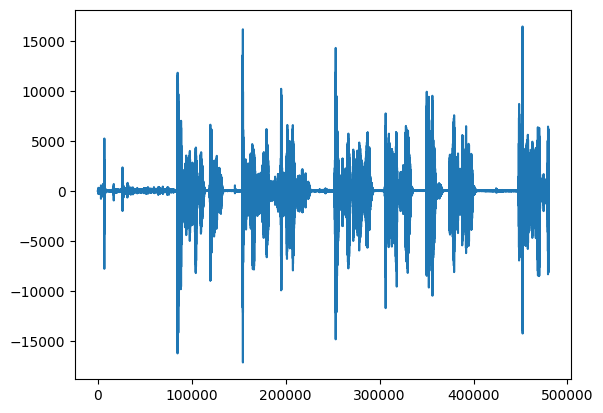

9600000
[]
''


In [12]:
def process (audio) :

    # write('data/output1.wav', 16000, audio) # Save as WAV file
    audio_seg = AudioSegment.from_file (io.BytesIO(audio), sample_width=2, channels=1, frame_rate=16000, format='raw')

    mp3 = audio_seg.set_frame_rate(16000)
    mp3 = mp3.set_channels(1)

    waveform = mp3.get_array_of_samples()
    wave_arr = np.asarray(waveform, dtype=np.float32)

    buf = wave_arr [0:16000*30] ### 30초 for whisper chunk
    buf = wave_arr
    buf_len = len(buf)  # of frame rate 16000 -> 30
    print (buf_len)

    speech_timestamps = getVAD (buf)

    pprint (speech_timestamps)
    if len (speech_timestamps) == 0 :
        return ''

    # merge all speech chunks to one audio
    save_audio('only_speech.wav', collect_chunks(speech_timestamps, buf), sampling_rate=SAMPLING_RATE) 
    Audio('only_speech.wav')


    # trascribe the whole voice active audio of buf
    # get the first and last timestamp
    start = speech_timestamps[0] ['start']
    end   = speech_timestamps[-1]['end']

    so = max (int (start*16000 - padding), 0)     ### start offset
    eo = min (int (end*16000 + padding), buf_len) ### end offset

    wave_arr = buf[so:eo] ### audio to be trascribed

    result = transcribe_local (wave_arr)

    return result ['text']


audio_file = '/mnt/f/tmp/Web Dictation Files/tmp/23EW14Gautama041023.mp3'

audio = AudioSegment.from_file(audio_file, format='mp3')
audio = audio.set_frame_rate(16000)
audio = audio.set_channels(1)
audio = audio.get_array_of_samples()
audio = np.asarray(audio, dtype=np.float32)


# draw the waveform
import matplotlib.pyplot as plt
plt.plot(audio [0:16000*30])
plt.show()


text = process (audio [0:16000*300])

import json
import pprint

def JPRINT (json_data) : ### 한글 잘 처리됨
    pp = pprint.PrettyPrinter (indent=4)
    pp.pprint (json_data)

JPRINT (text)


Using cache found in /home/choice/.cache/torch/hub/snakers4_silero-vad_master


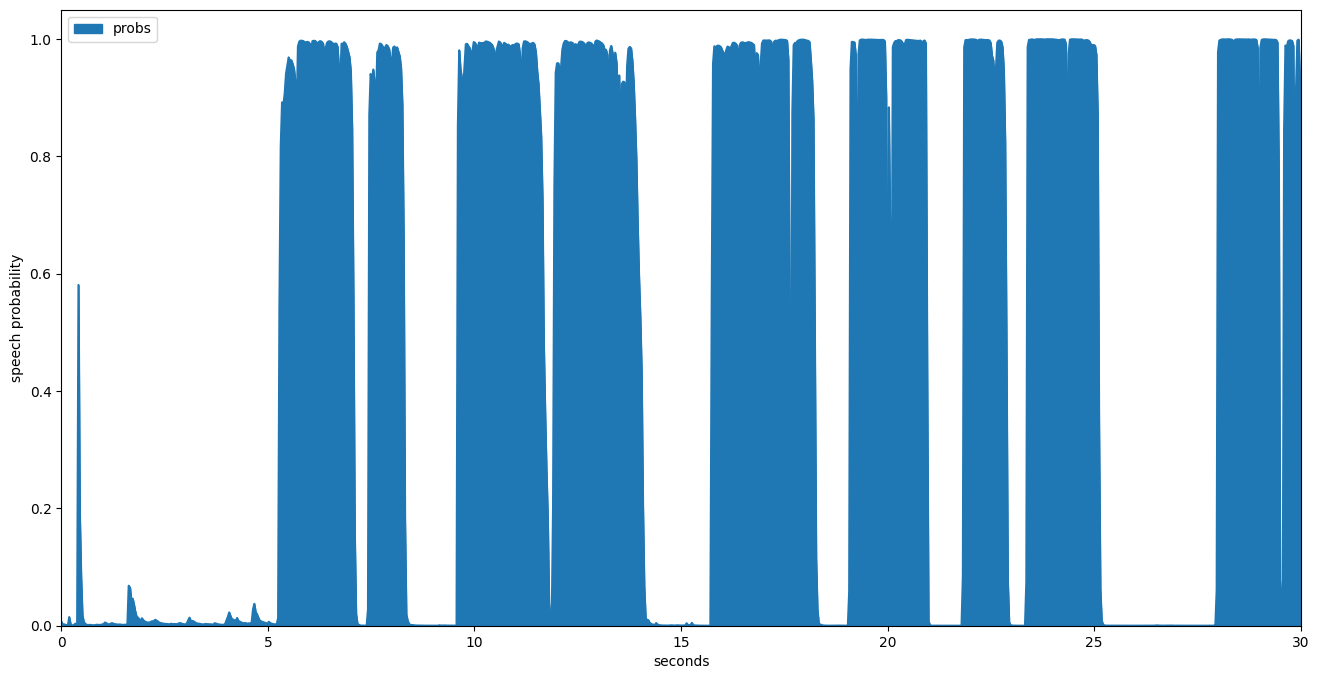

In [18]:
import torch
torch.set_num_threads(1)

model_vad, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad')
(get_speech_timestamps, _, read_audio, _, _) = utils

audio_file = '/mnt/f/tmp/Web Dictation Files/tmp/ct/14.wav'

wav = read_audio(audio_file, sampling_rate=16000) [:16000*30]
speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=16000, visualize_probs=True, return_seconds=True)

In [19]:
speech_timestamps

[{'start': 5.2, 'end': 7.1},
 {'start': 7.4, 'end': 8.3},
 {'start': 9.6, 'end': 11.8},
 {'start': 11.9, 'end': 14.1},
 {'start': 15.7, 'end': 18.3},
 {'start': 19.1, 'end': 21.0},
 {'start': 21.8, 'end': 22.9},
 {'start': 23.4, 'end': 25.1},
 {'start': 28.0, 'end': 30.0}]

In [41]:
ss = speech_timestamps [0] ['start']
ss = 0
result = transcribe_local (audio [int (16000*ss):int (16000*(ss+30))])

In [42]:
pprint (result) # from 0 to 30 seconds

{'language': 'en',
 'segments': [{'avg_logprob': -0.23080550134181976,
               'compression_ratio': 1.432748538011696,
               'end': 10.04,
               'id': 0,
               'no_speech_prob': 0.12909629940986633,
               'seek': 0,
               'start': 4.88,
               'temperature': 0.0,
               'text': ' I am the ascended master, Gautama Buddha.',
               'tokens': [50363,
                          314,
                          716,
                          262,
                          44440,
                          4958,
                          11,
                          402,
                          2306,
                          1689,
                          19154,
                          13,
                          50849],
               'words': [{'end': 5.52,
                          'probability': 0.6417011618614197,
                          'start': 4.88,
                          'word': ' I'},
            

In [40]:
pprint (result) # from 4.8 to 34.8 seconds

{'language': 'en',
 'segments': [{'avg_logprob': -0.26281295587987075,
               'compression_ratio': 1.4780487804878049,
               'end': 4.84,
               'id': 0,
               'no_speech_prob': 0.02253028377890587,
               'seek': 0,
               'start': 0.0,
               'temperature': 0.0,
               'text': ' I am the ascended master, Gautama Buddha.',
               'tokens': [50363,
                          314,
                          716,
                          262,
                          44440,
                          4958,
                          11,
                          402,
                          2306,
                          1689,
                          19154,
                          13,
                          50579],
               'words': [{'end': 0.4,
                          'probability': 0.7117964625358582,
                          'start': 0.0,
                          'word': ' I'},
               

In [36]:
import ffmpeg

def downSample (in_name, out_name) :
    try :
        audio  = ffmpeg.input  (in_name).audio
        stream = ffmpeg.output (audio, out_name, **{'ar': '16000', 'acodec': 'mp3'}).overwrite_output ()
        out    = ffmpeg.run    (stream, capture_stdout=True, capture_stderr=True)
    except Exception as e :
        print (e)
###


def trimAudio (in_name, trim_time, out_name) :
    try :
        audio  = ffmpeg.input  (in_name).audio
        stream = ffmpeg.output (audio, out_name, **{'ss': trim_time, 'c': 'copy'}).overwrite_output ()
        # out    = ffmpeg.run    (stream, capture_stdout=False, capture_stderr=False)
        out    = ffmpeg.run    (stream, capture_stdout=True, capture_stderr=True)
    except Exception as e :
        print (e)
###

In [37]:
audio_file = '/mnt/f/tmp/Web Dictation Files/tmp/23EW14Gautama041023.mp3'
out_file = '/mnt/f/tmp/Web Dictation Files/tmp/ct/crop.mp3'

trimAudio (audio_file, '00:00:05.200', out_file)
# trimAudio (audio_file, '00:00:04.800', out_file)